In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [2]:
tf.reset_default_graph()
k = 2
max_iterations = 100

In [3]:
filenames = tf.train.match_filenames_once('./audio_dataset/*.wav', name='filenames')
count_num_files = tf.size(filenames, name = 'count_files')
filename_queue = tf.train.string_input_producer(filenames, name='generate_filenames')
reader = tf.WholeFileReader()

In [4]:
filename, file_contents = reader.read(filename_queue)
chromo = tf.placeholder(tf.float32)
max_freqs = tf.argmax(chromo, 0)

In [5]:
def get_next_chromogram(sess):
    audio_file = sess.run(filename)
    print('Loading {}'.format(audio_file))
    y, sr = librosa.load(audio_file)
    mat = librosa.feature.chroma_stft(y,sr=sr, n_fft=16384, hop_length=2205)
    return mat, audio_file

In [6]:
def extract_feature_vector(sess, chromo_data):
    num_features, num_samples = np.shape(chromo_data)
    freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    normalized_hist = hist.astype(float) / num_samples
    return normalized_hist

In [59]:
def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    xs = list()
    names = list()
    
    for j in range(num_files):
        plt.figure()
        chromo_data, filename = get_next_chromogram(sess)
        filename = filename.decode('utf_8')
        print(filename)
        plt.subplot(1, 2, 1)
        plt.imshow(chromo_data, cmap='Greys', interpolation='nearest')
        plt.title('Visualization of Sound Spectrum')

        plt.subplot(1, 2, 2)
        freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
        plt.hist(freq_vals)
        plt.title('Histogram of Notes')
        plt.xlabel('Musical Note')
        plt.ylabel('Count')
        plt.savefig('{}.png'.format(filename), format='png')
        plt.show()
        names.append(filename)
        x = extract_feature_vector(sess, chromo_data)
        xs.append(x)
    xs = np.asmatrix(xs)
    coord.request_stop()
    coord.join(threads)
    return xs, names

In [60]:
def initial_cluster_centroids(X, k):
    return X[0:k, :]


def assign_cluster(X, centroids):
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    return mins


def recompute_centroids(X, Y):
    sums = tf.unsorted_segment_sum(X, Y, k)
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)
    return sums / counts

Loading b'.\\audio_dataset\\scream_3.wav'
.\audio_dataset\scream_3.wav


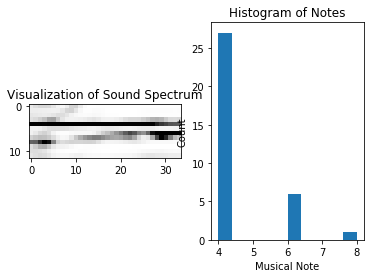

Loading b'.\\audio_dataset\\scream_1.wav'
.\audio_dataset\scream_1.wav


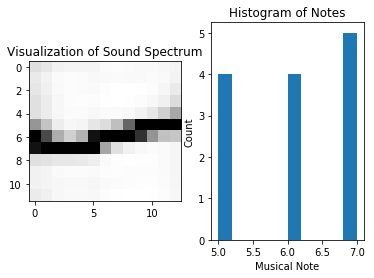

Loading b'.\\audio_dataset\\cough_1.wav'
.\audio_dataset\cough_1.wav


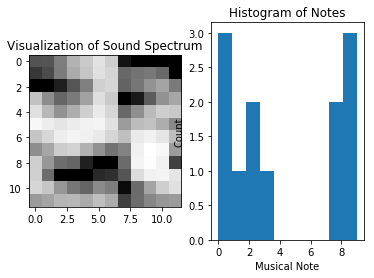

Loading b'.\\audio_dataset\\scream_2.wav'
.\audio_dataset\scream_2.wav


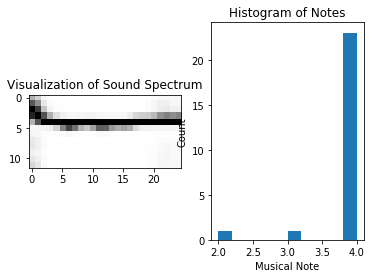

Loading b'.\\audio_dataset\\cough_2.wav'
.\audio_dataset\cough_2.wav


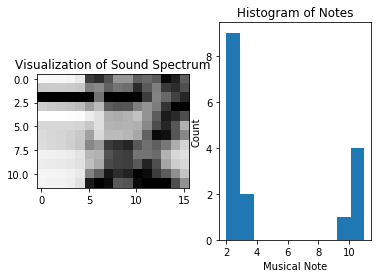

[(0, '.\\audio_dataset\\scream_3.wav'), (1, '.\\audio_dataset\\scream_1.wav'), (1, '.\\audio_dataset\\cough_1.wav'), (0, '.\\audio_dataset\\scream_2.wav'), (1, '.\\audio_dataset\\cough_2.wav')]


In [61]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    X, names = get_dataset(sess)
    centroids = initial_cluster_centroids(X, k)
    i, converged = 0, False
    while not converged and i < max_iterations:
        i += 1
        Y = assign_cluster(X, centroids)
        centroids = sess.run(recompute_centroids(X, Y))
    print(list(zip(sess.run(Y), names)))